In [2]:
import numpy as np
from math import *
from copy import deepcopy
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.visualization import iplot_state_city, plot_bloch_multivector, plot_state_paulivec
import matplotlib.pyplot as plt

***Rotation of the measurement basis:***

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$

Qiskit operates under the standard basis {$\ket{0}$ , $\ket{1}$}. A rotation of the measurement basis can be thought of changing the perspective. For example, if |0> represented $\ket{\uparrow}$ and |1> as |$\downarrow$> then the state

Basis: {$\ket{\uparrow}$, $\ket{\downarrow}$}

$\ket{\rightarrow}= \frac {1}{\sqrt{2}}(\ket{\uparrow} + \ket{\downarrow}) $

under the standard basis. 
However, you can also represent:

Basis: {$\ket{\rightarrow}$, $\ket{\leftarrow}$}

$\ket{\uparrow} = \frac {1}{\sqrt{2}}(\ket{\rightarrow} + \ket{\leftarrow})$

where the basis vectors are now $\ket{\rightarrow}$ and $\ket{\leftarrow}$.

So, rotating the measurement basis means changing the basis vectors to be in the direction of the originally superposed state.

Even though Qiskit maintains the same names for the axis, the rotation gates allow one to change the measurement basis so that the basis vectors point in the direction of the state being considered. The example below applies an H-gate which creates a superposition. The rotation about y swaps the positive x with positive z and now since qiskit's measurement apparatus considers this to be the z-axis (even though it's the x-axis in disguise) and the state corresponds to the basis vector of the measurement apparatus. The state is at 0, which implies that the qubit is in the positive x direction!

In [3]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q) #moves the state from positive z to positive x
circ.ry(-pi/2,q) #swaps x and z axis
circ.measure(q,c)
shots = 2000
job = execute(circ, backend = Aer.get_backend('qasm_simulator'), shots = shots)
counts = job.result().get_counts(circ)
print('Counts:' , counts)

Counts: {'0': 2000}


***State of a Qubit:***
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In order to determine the state of any circuit in some arbitrary state 

$\ket{\psi} = \alpha \ket{0} + \beta \ket{1}$

under the standard basis {|0> , |1>}, a measurement can be made and values for $|\alpha|^{2}$ and $|\beta|^{2}$ (the probabilities) are determined so then the following state vector is found:

$\ket{\psi} = \begin{bmatrix}
                    \alpha \\
                    \beta 
                    \end{bmatrix}$

where: $|\alpha|^{2} + |\beta|^{2} = 1$
However, there is some ambiguity here because it is unknown what the orientation of the qubit is. Taking advantage of the rotation of the axis and the counts, the x,y,z components can be determined and with these we can determine the angles $\theta$ and $\phi$ which will ultimately be used to find $\alpha$ and $\beta$:
$$\alpha = cos(\frac{\theta}{2})$$
$$\beta = sin(\frac{\theta}{2})e^{i\phi}$$

x-y-z Components: {'i': 0.723, 'j': -0.016, 'k': 0.737}
Angle theta: 42.52351524818539
Angle phi: -1.2677494652948735
State Vector: [0.-0.92387953j 0.-0.38268343j]
[[0.-0.924j 0.+0.383j]
 [0.-0.383j 0.-0.924j]]


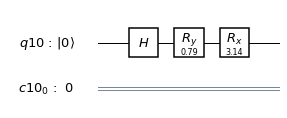

In [13]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q)
circ.ry(pi/4,q)
circ.rx(pi,q)

shots = 2000
def xyz_components(q,c,circ):
    #Measure z-component
    circ2 = QuantumCircuit(q,c)
    circ2.measure(q,c)
    
    circZ = circ + circ2
    job = execute(circZ, backend = Aer.get_backend('qasm_simulator'), shots = shots)
    counts = job.result().get_counts(circZ)
    z = (counts.get('0',0) - counts.get('1',0)) / shots
    
    #Measure x-component
    circ3 = QuantumCircuit(q,c)
    circ3.ry(-pi/2,q)
    circ3.measure(q,c)
    
    circX = circ + circ3
    job2 = execute(circX, backend = Aer.get_backend('qasm_simulator'), shots = shots)
    counts2 = job2.result().get_counts(circX)
    x = (counts2.get('0',0) - counts2.get('1',0)) / shots
    
    #Measure y-component
    circ4 = QuantumCircuit(q,c)
    circ4.rx(pi/2,q)
    circ4.measure(q,c)
    
    circY = circ + circ4
    job3 = execute(circY, backend = Aer.get_backend('qasm_simulator'), shots = shots)
    counts3 = job3.result().get_counts(circY)
    y = (counts3.get('0',0) - counts3.get('1',0)) / shots
    
    #Check norm of vector:
    norm = sqrt(x**2 + y**2 + z**2)
    if isclose(norm, 1,rel_tol = 0.05):
        result = {'i': x, 'j': y, 'k': z}
        return result
    else:
        print('Incorrect Components')

#Results:
res = xyz_components(q,c,circ)
print('x-y-z Components:', res)
print('Angle theta:', np.arccos(res['k'])*(180/pi))
print('Angle phi:' , np.arctan2(res['j'],res['i'])*(180/pi))
result = execute(circ, backend = BasicAer.get_backend('statevector_simulator')).result()
psi = result.get_statevector(circ)
print('State Vector:' , psi)
job = execute(circ, backend = BasicAer.get_backend('unitary_simulator'))
print(job.result().get_unitary(circ, decimals=3))
plot_bloch_multivector(psi)
#plot_state_paulivec(psi)

circ.draw(output='mpl')

***Determining Action of Gate from Measurement Counts:***

It is possible to determine what a gate does based on the measurement counts because if one rotates the axes and measures along each axis (just as the function above does) you can determine the state of your vector, |$\psi$>, and angles $\theta$ and $\phi$. Since the intial state on Qiskit is known to be |0>, you can use the properties of unitary matrices to work out:

U|0> = |$\psi$>

Say the gate we applied is an Z-gate, then we have:

$Z \begin{bmatrix}   
                    0 \\
                    1 
                    \end{bmatrix}$ = $\begin{bmatrix}
                                            0 \\
                                             -1 
                                             \end{bmatrix}$

So, since we know that:
$$Z = \begin{bmatrix}
                    a&&b \\
                    c&&d 
                    \end{bmatrix}$$
                    
We can generate 4 equations to solve for the four unknowns:
b = 0
d = -1
a = 1
b = 0

Counts: {'0': 987, '1': 1013}
State Vector: [0.70710678+0.j 0.70710678+0.j]


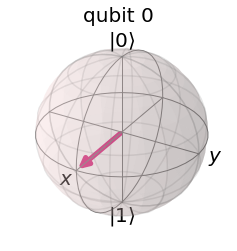

In [6]:
q = QuantumRegister(1)
c = ClassicalRegister(1)

circ = QuantumCircuit(q,c)
circ.h(q)

circ2 = QuantumCircuit(q,c)
circ2.measure(q,c)

final = circ + circ2

shots = 2000
job = execute(final, backend = Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(final)
print('Counts:', counts)

result = execute(circ, backend = BasicAer.get_backend('statevector_simulator')).result()
psi = result.get_statevector(circ)
print('State Vector:' , psi)
plot_bloch_multivector(psi)

Counts: {'0': 987, '1': 1013}
State Vector: [0.5+0.5j 0.5-0.5j]


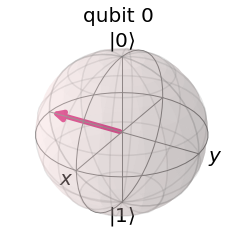

In [10]:
q = QuantumRegister(1)
c = ClassicalRegister(1)

circ = QuantumCircuit(q,c)
circ.rx(-pi/2,q)
circ.h(q)

circ2 = QuantumCircuit(q,c)
circ2.measure(q,c)

final = circ + circ2

shots = 2000
job = execute(final, backend = Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(final)
print('Counts:' , counts)

result = execute(circ, backend = BasicAer.get_backend('statevector_simulator')).result()
psi = result.get_statevector(circ)
print('State Vector:' , psi)
plot_bloch_multivector(psi)

The function of H-gate (Hadamard gate) is displayed. The H-gate creates a superposition by performing the following unitary transformation known as the Hadamard transform:
$$H = \frac {1}{\sqrt{2}} \begin{bmatrix}
                           1&1 \\
                           1&-1 
                           \end{bmatrix}$$
The results show that about half the time the qubit is 0 and half the time it is 1 for the case:

|0>$\rightarrow$ H|0> = $\frac{1}{\sqrt{2}}$ (|0> + |1>)

In [8]:
q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q,c)
circ.h(q)
circ.ry(-pi/4,q)
job = execute(circ, backend = BasicAer.get_backend('unitary_simulator'))
print(job.result().get_unitary(circ, decimals=3))

result = execute(circ, backend = BasicAer.get_backend('statevector_simulator')).result()
psi = result.get_statevector(circ)


[[ 0.924+0.j  0.383+0.j]
 [ 0.383+0.j -0.924+0.j]]


In [9]:
iplot_state_city(psi)